# Setup 

In [61]:
import ccxt
import time
import logging
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta, datetime
from utils import from_exchange_to_standard_notation, from_standard_to_exchange_notation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings


plt.rcParams['figure.figsize'] = 15,10
warnings.filterwarnings('ignore')

# Load Data 

In [4]:
data1 = pd.read_csv('tradedata/20190723.csv.gz')
data2 = pd.read_csv('tradedata/20190724.csv.gz')
data3 = pd.read_csv('tradedata/20190725.csv.gz')
data4 = pd.read_csv('tradedata/20190726.csv.gz')

data = data1
data = data.append(data2)
data = data.append(data3)
data = data.append(data4)

In [10]:
btc_data = data[data.symbol == 'XBTUSD']
btc_data['time'] = btc_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
btc_data.set_index('time', inplace=True)
ethusd_data = data[data.symbol == 'ETHUSD']
ethusd_data['time'] = ethusd_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
ethusd_data.set_index('time', inplace=True)
ethbtc_data = data[data.symbol == 'ETHU19']
ethbtc_data['time'] = ethbtc_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
ethbtc_data.set_index('time', inplace=True)
eosbtc_data = data[data.symbol == 'EOSU19']
eosbtc_data['time'] = eosbtc_data.timestamp.map(lambda t: datetime.strptime(t[:-3], "%Y-%m-%dD%H:%M:%S.%f"))
eosbtc_data.set_index('time', inplace=True)

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
time,,,,,,,,,,
2019-07-23 00:00:44.471498,2019-07-23D00:00:44.471498000,EOSU19,Buy,10,0.000399,PlusTick,9b576815-02e0-458c-afa4-6064368e807a,398600,10.0,0.003986
2019-07-23 00:00:49.262435,2019-07-23D00:00:49.262435000,EOSU19,Buy,61,0.000399,ZeroPlusTick,5d326cfe-af68-ca1a-859e-5f2c500414b2,2431460,61.0,0.024315
2019-07-23 00:00:50.642206,2019-07-23D00:00:50.642206000,EOSU19,Buy,61,0.000399,ZeroPlusTick,6757234d-8895-2a56-8102-bd22623720c0,2431460,61.0,0.024315
2019-07-23 00:00:52.322646,2019-07-23D00:00:52.322646000,EOSU19,Buy,342,0.000399,PlusTick,5e9b8c0c-8643-ce62-8ce8-926d4b069e48,13638960,342.0,0.136390
2019-07-23 00:00:52.322646,2019-07-23D00:00:52.322646000,EOSU19,Buy,2159,0.000399,PlusTick,4fb99de6-6a84-5b0f-0590-6afeee832302,86122510,2159.0,0.861225


In [44]:
ethusd_data.head(20)

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
time,,,,,,,,,,
2019-07-23 00:00:06.837166,2019-07-23D00:00:06.837166000,ETHUSD,Sell,26,217.20,MinusTick,bcb66194-8dc4-9cf0-402c-afc3fc89813a,564720,0.268429,58.302700
2019-07-23 00:00:06.837166,2019-07-23D00:00:06.837166000,ETHUSD,Sell,23,217.20,ZeroMinusTick,e7124cfd-1638-2cc5-1190-ee2db7bad825,499560,0.237456,51.575470
2019-07-23 00:00:06.837166,2019-07-23D00:00:06.837166000,ETHUSD,Sell,151,217.20,ZeroMinusTick,c18a811f-9855-4291-9c75-d7c542801f67,3279720,1.558951,338.604200
2019-07-23 00:00:06.983625,2019-07-23D00:00:06.983625000,ETHUSD,Sell,1628,217.20,ZeroMinusTick,9e025e5d-2045-1e57-b85a-f9cf7cbc458e,35360160,16.807760,3650.646000
2019-07-23 00:00:08.460624,2019-07-23D00:00:08.460624000,ETHUSD,Sell,1,217.20,ZeroMinusTick,a7d09dda-8de6-8a1b-5ed3-ec66b2005506,21720,0.010324,2.242412
2019-07-23 00:00:08.567984,2019-07-23D00:00:08.567984000,ETHUSD,Sell,220,217.20,ZeroMinusTick,16929315-eae2-14ad-3f0d-5f49039c99e9,4778400,2.271319,493.330600
2019-07-23 00:00:08.567984,2019-07-23D00:00:08.567984000,ETHUSD,Sell,1000,217.20,ZeroMinusTick,93962409-c96a-8a83-2b7e-c298c44cc511,21720000,10.324180,2242.412000
2019-07-23 00:00:08.567984,2019-07-23D00:00:08.567984000,ETHUSD,Sell,2780,217.20,ZeroMinusTick,e7b7f96f-45b7-2707-1256-291ef603da72,60381600,28.701220,6233.905000
2019-07-23 00:00:08.663860,2019-07-23D00:00:08.663860000,ETHUSD,Sell,220,217.20,ZeroMinusTick,ce973b16-bedc-a263-1119-fc09f1b79010,4778400,2.271319,493.330600


In [51]:
class BarSeries(object):
    '''
        Base class for resampling ticks dataframe into OHLC(V)
        using different schemes. This particular class implements
        standard time bars scheme.
        See: https://www.wiley.com/en-it/Advances+in+Financial+Machine+Learning-p-9781119482086
    '''
    
    def __init__(self, df, datetimecolumn = 'time'):
        self.df = df
        self.datetimecolumn = datetimecolumn
    
    def process_column(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').ohlc()
    
    def process_volume(self, column_name, frequency):
        return self.df[column_name].resample(frequency, label='right').sum()
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = '5T'):
        price_df = self.process_column(price_column, frequency)
        volume_df = self.process_volume(volume_column, frequency)
        price_df['volume'] = volume_df
        return price_df
    

class TickBarSeries(BarSeries):
    '''
        Class for generating tick bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(TickBarSeries, self).__init__(df, datetimecolumn)
    
    def process_column(self, column_name, frequency):
        res = []
        for i in range(frequency, len(self.df), frequency):
            sample = self.df.iloc[i-frequency:i]
            v = sample[self.volume_column].values.sum()
            o = sample[column_name].values.tolist()[0]
            h = sample[column_name].values.max()
            l = sample[column_name].values.min()
            c = sample[column_name].values.tolist()[-1]
            d = sample.index.values[-1]
            
            res.append({
                self.datetimecolumn: d,
                'open': o,
                'high': h,
                'low': l,
                'close': c,
                'volume': v
            })

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res

    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = '15Min'):
        price_df = self.process_column(price_column, frequency)
        return price_df    
    

class VolumeBarSeries(BarSeries):
    '''
        Class for generating volume bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(VolumeBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf = []
        start_index = 0.
        volume_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            
            buf.append(pi)
            volume_buf += vi
            
            if volume_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,  
                    'volume': volume_buf
                })
                
                buf, volume_buf = [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df    
    

class QuoteCurrencyVolumeBarSeries(BarSeries):
    '''
        Class for generating "dollar" bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(QuoteCurrencyVolumeBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf, vbuf = [], []
        start_index = 0.
        dollar_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            dvi = self.df['foreignNotional'].iloc[i]
            buf.append(pi)
            vbuf.append(vi)
            dollar_buf += dvi
            
            if dollar_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v,
                    'dollar': dollar_buf
                })
                
                buf, vbuf, dollar_buf = [], [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df
    
    
    
class BaseCurrencyVolumeBarSeries(BarSeries):
    '''
        Class for generating "dollar" bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(BaseCurrencyVolumeBarSeries, self).__init__(df, datetimecolumn)
               
    def process_column(self, column_name, frequency):
        res = []
        buf, vbuf = [], []
        start_index = 0.
        dollar_buf = 0.
        for i in range(len(self.df[column_name])):

            pi = self.df[column_name].iloc[i]
            vi = self.df[self.volume_column].iloc[i]
            di = self.df.index.values[i]
            dvi = self.df['homeNotional'].iloc[i]
            buf.append(pi)
            vbuf.append(vi)
            dollar_buf += dvi
            
            if dollar_buf >= frequency:
                
                o = buf[0]
                h = np.max(buf)
                l = np.min(buf)
                c = buf[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v,
                    'dollar': dollar_buf
                })
                
                buf, vbuf, dollar_buf = [], [], 0.

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', frequency = 10000):
        price_df = self.process_column(price_column, frequency)
        return price_df
    
    

class ImbalanceTickBarSeries(BarSeries):
    '''
        Class for generating imbalance tick bars based on bid-ask-size dataframe
    '''
    def __init__(self, df, datetimecolumn = 'time', volume_column = 'size'):
        self.volume_column = volume_column
        super(ImbalanceTickBarSeries, self).__init__(df, datetimecolumn)
        
    def get_bt(self, data):
        s = np.sign(np.diff(data))
        for i in range(1, len(s)):
            if s[i] == 0:
                s[i] = s[i-1]
        return s

    def get_theta_t(self, bt):
        return np.sum(bt)

    def ewma(self, data, window):

        alpha = 2 /(window + 1.0)
        alpha_rev = 1-alpha

        scale = 1/alpha_rev
        n = data.shape[0]

        r = np.arange(n)
        scale_arr = scale**r
        offset = data[0]*alpha_rev**(r+1)
        pw0 = alpha*alpha_rev**(n-1)

        mult = data*pw0*scale_arr
        cumsums = mult.cumsum()
        out = offset + cumsums*scale_arr[::-1]
        return out
               
    def process_column(self, column_name, initital_T = 100, min_bar = 10, max_bar = 1000):
        init_bar = self.df[:initital_T][column_name].values.tolist()

        ts = [initital_T]
        bts = [bti for bti in self.get_bt(init_bar)]  
        res = []

        buf_bar, vbuf, T = [], [], 0.
        for i in range(initital_T, len(self.df)):

 
            di = self.df.index.values[i]

            buf_bar.append(self.df[column_name].iloc[i])
            bt = self.get_bt(buf_bar)
            theta_t = self.get_theta_t(bt)

            try:
                e_t = self.ewma(np.array(ts), initital_T / 10)[-1]
                e_bt = self.ewma(np.array(bts), initital_T)[-1]
            except:
                e_t = np.mean(ts)
                e_bt = np.mean(bts)
            finally:                   
                if np.isnan(e_bt):
                    e_bt = np.mean(bts[int(len(bts) * 0.9):])
                if np.isnan(e_t):
                    e_t = np.mean(ts[int(len(ts) * 0.9):])

                
            condition = np.abs(theta_t) >= e_t * np.abs(e_bt)

            
            if (condition or len(buf_bar) > max_bar) and len(buf_bar) >= min_bar:

                o = buf_bar[0]
                h = np.max(buf_bar)
                l = np.min(buf_bar)
                c = buf_bar[-1]
                v = np.sum(vbuf)
                
                res.append({
                    self.datetimecolumn: di,
                    'open': o,
                    'high': h,
                    'low': l,
                    'close': c,
                    'volume': v
                })
                
                ts.append(T)
                for b in bt:
                    bts.append(b) 
                    
                buf_bar = []
                vbuf = []
                T = 0.           
            else:
                vbuf.append(self.df[self.volume_column].iloc[i])
                T += 1

        res = pd.DataFrame(res).set_index(self.datetimecolumn)
        return res 
    
    def process_ticks(self, price_column = 'price', volume_column = 'size', init = 100, min_bar = 10, max_bar = 1000):
        price_df = self.process_column(price_column, init, min_bar, max_bar)
        return price_df  

## Compute Adcanced BTC/USD bars

In [ ]:
# Number of bars for normal 5 min candlesticks (for 4 days data)
number_1_min_candles = 24 * 60 * 4 
number_5_min_candles = 24 * 60 * 4 / 5
number_15_min_candles = 24 * 60 * 4 / 15
number_1h_candles = 24 * 4

total_trades = btc_data.shape[0]
total_contract_volume = ethusd_data['size'].sum()
total_dollar_volume = ethusd_data['foreignNotional'].sum()
total_bitcoin_volume = ethusd_data['homeNotional'].sum()

recommended_tick_frequency = total_trades / number_1_min_candles
recommended_volume_frequency = total_contract_volume / number_1_min_candles
recommended_dollar_frequency = total_dollar_volume / number_1_min_candles
recommended_bitcoin_frequency = total_bitcoin_volume / number_1_min_candles

print('Amounts and Volumes')
print(total_volume)
print(total_trades)
print(total_dollar_volume)
print(total_bitcoin_volume)

print('Recommended frequencies')
print(recommended_tick_frequency)
print(recommended_volume_frequency)
print(recommended_dollar_frequency)
print(recommended_bitcoin_frequency)


btcusd_time_bars = BarSeries(btc_data).process_ticks(frequency='1min')
# here dollar volume = contract volume
btcusd_volume_bars = VolumeBarSeries(btcusd_data).process_ticks(frequency=2000000)
# here base currency = BTC
btcusd_bitcoin_bars = BaseCurrencyVolumeBarSeries(btcusd_data).process_ticks(frequency=200)
btcusd_tick_bars = TickBarSeries(btcusd_data).process_ticks(frequency=500)

num_time_bars = btcusd_time_bars.shape[0]
num_volume_bars = btcusd_volume_bars.shape[0]
num_bitcoin_bars = btcusd_bitcoin_bars.shape[0]
num_tick_bars = btcusd_tick_bars.shape[0]

print('Number of bars')
print(num_time_bars)
print(num_volume_bars)
print(num_bitcoin_bars)
print(num_tick_bars)

# //imbalance_bars = ImbalanceTickBarSeries(btc_data).process_ticks(init = 100, min_bar = 10, max_bar = 1000)

## Compute advanced ETH/USD bars

In [110]:
# Number of bars for normal 5 min candlesticks (for 4 days data)
number_1_min_candles = 24 * 60 * 4 
number_5_min_candles = 24 * 60 * 4 / 5
number_15_min_candles = 24 * 60 * 4 / 15
number_1h_candles = 24 * 4

total_trades = ethusd_data.shape[0]
total_contract_volume = ethusd_data['size'].sum()
total_dollar_volume = ethusd_data['foreignNotional'].sum()
total_ethereum_volume = ethusd_data['homeNotional'].sum()

recommended_tick_frequency = total_trades / number_1_min_candles
recommended_volume_frequency = total_contract_volume / number_1_min_candles
recommended_dollar_frequency = total_dollar_volume / number_1_min_candles
recommended_ethereum_frequency = total_ethereum_volume / number_1_min_candles

print('Amounts and Volumes')
print(total_volume)
print(total_trades)
print(total_dollar_volume)
print(total_ethereum_volume)

print('Recommended frequencies')
print(recommended_tick_frequency)
print(recommended_volume_frequency)
print(recommended_dollar_frequency)
print(recommended_ethereum_frequency)

ethusd_time_bars = BarSeries(ethusd_data).process_ticks(frequency='1min')
ethusd_tick_bars = TickBarSeries(ethusd_data).process_ticks(frequency=60)
ethusd_volume_bars = VolumeBarSeries(ethusd_data).process_ticks(frequency=60000)
ethusd_dollar_bars = QuoteCurrencyVolumeBarSeries(ethusd_data).process_ticks(frequency=125000)
ethusd_ethereum_bars = BaseCurrencyVolumeBarSeries(ethusd_data).process_ticks(frequency=600)

# Compute Returns
ethusd_time_bar_returns = ethusd_time_bars.close.pct_change().dropna()
ethusd_tick_bar_returns= ethusd_tick_bars.close.pct_change().dropna()
ethusd_volume_bar_returns= ethusd_volume_bars.close.pct_change().dropna()
ethusd_ethereum_bars_returns= ethusd_ethereum_bars.close.pct_change().dropna()
ethusd_dollar_bars_returns= ethusd_dollar_bars.close.pct_change().dropna()

num_time_bars = ethusd_time_bars.shape[0]
num_volume_bars = ethusd_volume_bars.shape[0]
num_ethereum_bars = ethusd_ethereum_bars.shape[0]
num_tick_bars = ethusd_tick_bars.shape[0]
num_dollar_bars = ethusd_dollar_bars.shape[0]

print('Number of bars')
print(num_time_bars)
print(num_volume_bars)
print(num_ethereum_bars)
print(num_dollar_bars)
print(num_tick_bars)

Amounts and Volumes
343448152
328224
728307131.6151
3391303.500858571
Recommended frequencies
56.983333333333334
59626.41527777778
126442.21034984375
588.7679688990575
Number of bars
5760
5061
4999
5148
5470


## Compute advanced ETH/BTC bars

In [ ]:
# Number of bars for normal 5 min candlesticks (for 4 days data)
number_1_min_candles = 24 * 60 * 4 
number_5_min_candles = 24 * 60 * 4 / 5
number_15_min_candles = 24 * 60 * 4 / 15
number_1h_candles = 24 * 4

total_trades = ethbtc_data.shape[0]
total_contract_volume = ethbtc_data['size'].sum()
total_bitcoin_volume = ethbtc_data['foreignNotional'].sum()
total_ethereum_volume = ethbtc_data['homeNotional'].sum()

recommended_tick_frequency = total_trades / number_5_min_candles
recommended_volume_frequency = total_contract_volume / number_5_min_candles
recommended_bitcoin_frequency = total_bitcoin_volume / number_5_min_candles
recommended_ethereum_frequency = total_ethereum_volume / number_5_min_candles

print('Amounts and Volumes')
print(total_volume)
print(total_trades)
print(total_bitcoin_volume)
print(total_ethereum_volume)

print('Recommended frequencies')
print(recommended_tick_frequency)
print(recommended_volume_frequency)
print(recommended_bitcoin_frequency)
print(recommended_ethereum_frequency)

ethbtc_time_bars = BarSeries(ethbtc_data).process_ticks(frequency='5min')
ethbtc_tick_bars = TickBarSeries(ethbtc_data).process_ticks(frequency=10)
ethbtc_volume_bars = VolumeBarSeries(ethbtc_data).process_ticks(frequency=135)
ethbtc_bitcoin_bars = QuoteCurrencyVolumeBarSeries(ethbtc_data).process_ticks(frequency=3)
ethbtc_ethereum_bars = BaseCurrencyVolumeBarSeries(ethbtc_data).process_ticks(frequency=135)


# Compute Returns
ethbtc_time_bar_returns = ethbtc_time_bars.close.pct_change().dropna()
ethbtc_tick_bar_returns= ethbtc_tick_bars.close.pct_change().dropna()
ethbtc_volume_bar_returns= ethbtc_volume_bars.close.pct_change().dropna()
ethbtc_ethereum_bars_returns= ethbtc_ethereum_bars.close.pct_change().dropna()
ethbtc_bitcoin_bars_returns= ethbtc_bitcoin_bars.close.pct_change().dropna()

num_time_bars = ethbtc_time_bars.shape[0]
num_volume_bars = ethbtc_volume_bars.shape[0]
num_bitcoin_bars = ethbtc_bitcoin_bars.shape[0]
num_tick_bars = ethbtc_tick_bars.shape[0]
num_ethereum_bars = ethbtc_ethereum_bars.shape[0]

print('Number of bars')
print(num_time_bars)
print(num_volume_bars)
print(num_ethereum_bars)
print(num_bitcoin_bars)
print(num_tick_bars)

## Compute advanced EOS/BTC bars

In [111]:
# Number of bars for normal 5 min candlesticks (for 4 days data)
number_1_min_candles = 24 * 60 * 4 
number_5_min_candles = 24 * 60 * 4 / 5
number_15_min_candles = 24 * 60 * 4 / 15
number_1h_candles = 24 * 4

number_of_candles = number_1_min_candles

total_trades = eosbtc_data.shape[0]
total_contract_volume = eosbtc_data['size'].sum()
total_bitcoin_volume = eosbtc_data['foreignNotional'].sum()
total_eos_volume = eosbtc_data['homeNotional'].sum()

recommended_tick_frequency = total_trades / number_of_candles
recommended_volume_frequency = total_contract_volume / number_of_candles
recommended_bitcoin_frequency = total_bitcoin_volume / number_of_candles
recommended_eos_frequency = total_eos_volume / number_of_candles

print('Amounts and Volumes')
print(total_volume)
print(total_trades)
print(total_bitcoin_volume)
print(total_eos_volume)

print('Recommended frequencies')
print(recommended_tick_frequency)
print(recommended_volume_frequency)
print(recommended_bitcoin_frequency)
print(recommended_eos_frequency)


eosbtc_time_bars = BarSeries(eosbtc_data).process_ticks(frequency='1min')
eosbtc_tick_bars = TickBarSeries(eosbtc_data).process_ticks(frequency=round(recommended_tick_frequency))
eosbtc_volume_bars = VolumeBarSeries(eosbtc_data).process_ticks(frequency=round(recommended_volume_frequency))
eosbtc_bitcoin_bars = QuoteCurrencyVolumeBarSeries(eosbtc_data).process_ticks(frequency=recommended_bitcoin_frequency)
eosbtc_eos_bars = BaseCurrencyVolumeBarSeries(eosbtc_data).process_ticks(frequency=round(recommended_eos_frequency))


# Compute Returns
eosbtc_time_bar_returns = eosbtc_time_bars.close.pct_change().dropna()
eosbtc_tick_bar_returns= eosbtc_tick_bars.close.pct_change().dropna()
eosbtc_volume_bar_returns= eosbtc_volume_bars.close.pct_change().dropna()
eosbtc_eos_bars_returns= eosbtc_eos_bars.close.pct_change().dropna()
eosbtc_bitcoin_bars_returns= eosbtc_bitcoin_bars.close.pct_change().dropna()

num_time_bars = eosbtc_time_bars.shape[0]
num_volume_bars = eosbtc_volume_bars.shape[0]
num_bitcoin_bars = eosbtc_bitcoin_bars.shape[0]
num_tick_bars = eosbtc_tick_bars.shape[0]
num_eos_bars = eosbtc_eos_bars.shape[0]


print('Number of bars')
print(num_time_bars)
print(num_tick_bars)
print(num_volume_bars)
print(num_eos_bars)
print(num_bitcoin_bars)


Amounts and Volumes
343448152
29572
4552.8453142
10149433.0
Recommended frequencies
5.134027777777778
1762.0543402777778
0.7904245337152778
1762.0543402777778
Number of bars
5760
5914
3464
3464
3469


## Plot BTC/USD results

/Users/davidvanisacker/backtest/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


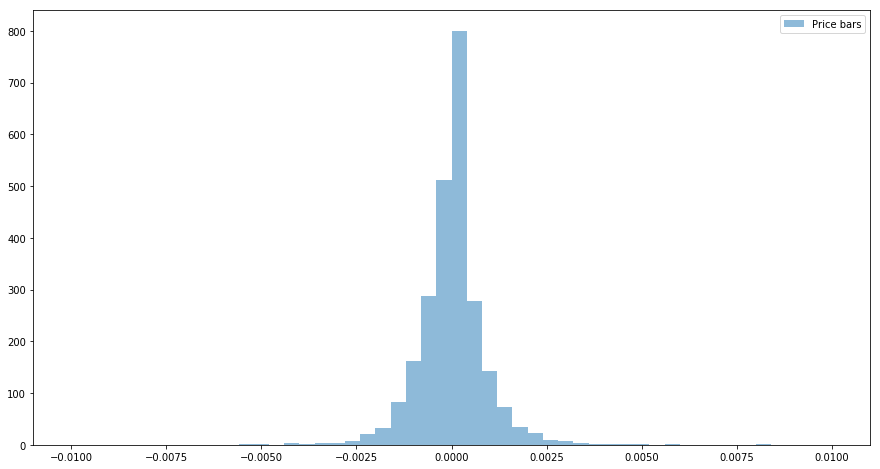

In [71]:
plt.figure(figsize = (15, 8))
plt.hist(time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (15, 8))
plt.hist(time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.hist(bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.4, normed=True, bins=50, range = (-0.01, 0.01))
plt.legend()
plt.show()

print('-' * 20)
print('-' * 20)
print("AUTOCORRELATIONS")
print(pd.Series.autocorr(time_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(tick_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(volume_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("VARIANCE")
print(np.var(time_bars.close.pct_change().dropna()))
print(np.var(tick_bars.close.pct_change().dropna()))
print(np.var(volume_bars.close.pct_change().dropna()))
print(np.var(bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("JARQUE BERA TEST")
print(stats.jarque_bera(time_bars.close.pct_change().dropna()))
print(stats.jarque_bera(tick_bars.close.pct_change().dropna()))
print(stats.jarque_bera(volume_bars.close.pct_change().dropna()))
print(stats.jarque_bera(bitcoin_bars.close.pct_change().dropna()))

## Plot ETH/USD Results

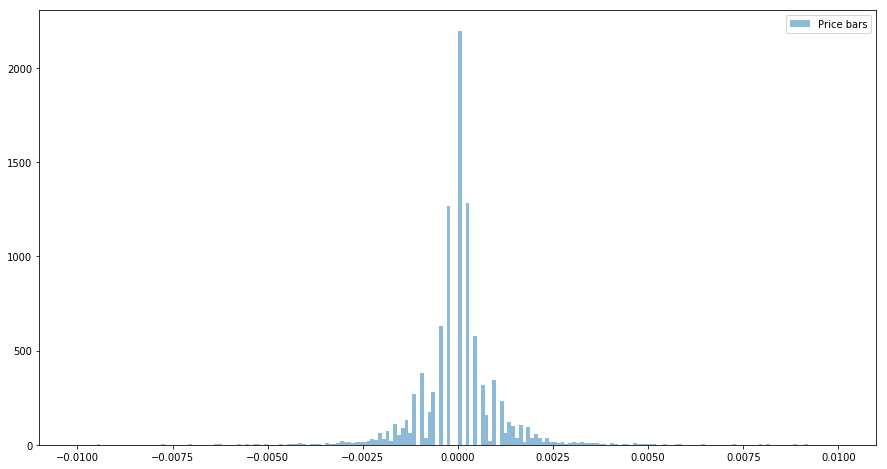

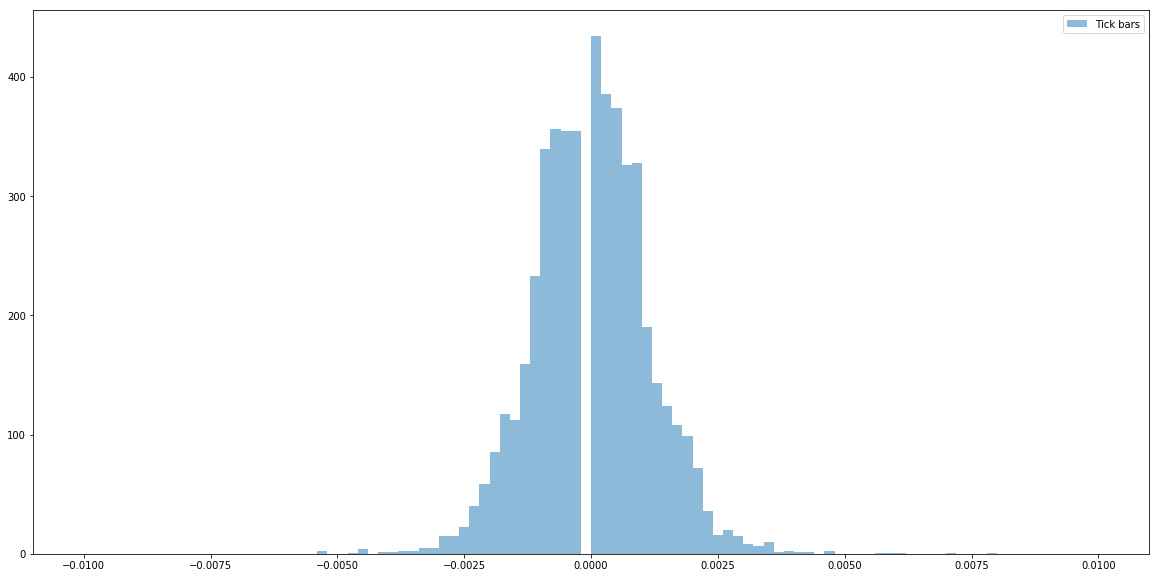

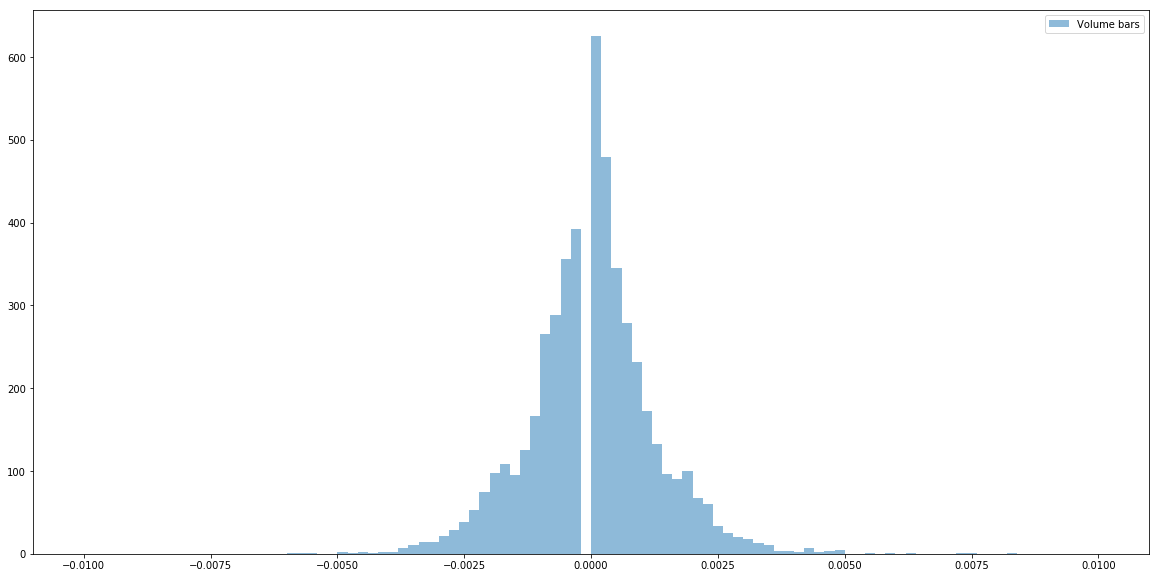

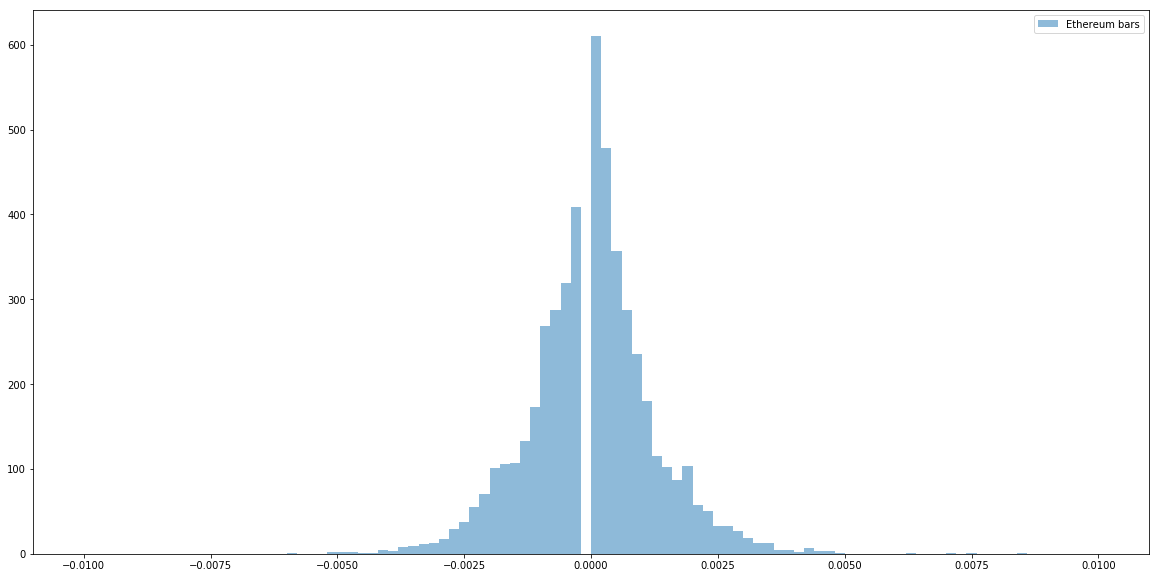

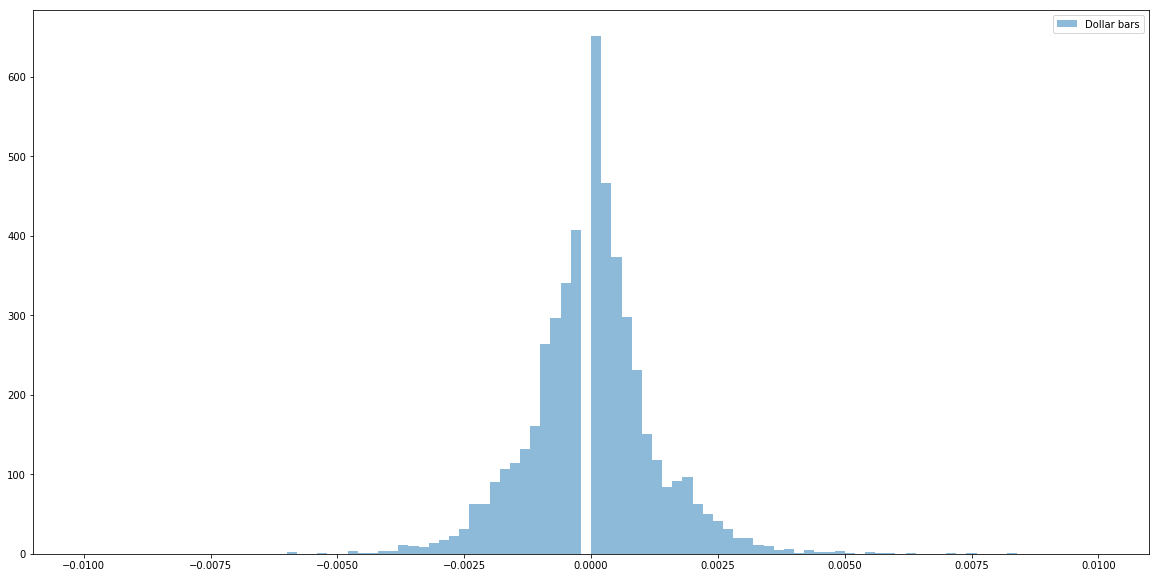

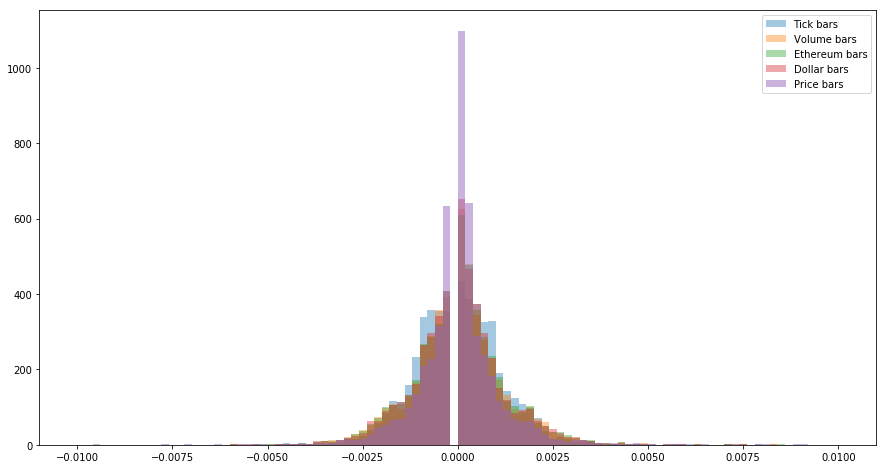

--------------------
--------------------
AUTOCORRELATIONS
0.10451004384148341
0.06438140258634541
0.04500250381950574
0.05984087441164528
0.05943772813672964
--------------------
--------------------
VARIANCE
1.4149379900780301e-06
1.3540201840327635e-06
1.5818572188902605e-06
1.571709782124188e-06
1.541828115532381e-06
--------------------
--------------------
JARQUE BERA TEST
(470.65051126886317, 0.0)
(909.609882228258, 0.0)
(751.4288028405456, 0.0)
(1090.3395891533248, 0.0)
(248480.10788893374, 0.0)


In [74]:
plt.figure(figsize = (15, 8))
plt.hist(ethusd_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=200, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethusd_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.5, normed=True, bins=100, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethusd_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.5, normed=True, bins=100, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethusd_ethereum_bars.close.pct_change().dropna().values.tolist(), label = 'Ethereum bars', alpha = 0.5, normed=True, bins=100, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethusd_dollar_bars.close.pct_change().dropna().values.tolist(), label = 'Dollar bars', alpha = 0.5, normed=True, bins=100, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (15, 8))

plt.hist(ethusd_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.4, normed=True, bins=100, range = (-0.01, 0.01))
plt.hist(ethusd_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.4, normed=True, bins=100, range = (-0.01, 0.01))
plt.hist(ethusd_ethereum_bars.close.pct_change().dropna().values.tolist(), label = 'Ethereum bars', alpha = 0.4, normed=True, bins=100, range = (-0.01, 0.01))
plt.hist(ethusd_dollar_bars.close.pct_change().dropna().values.tolist(), label = 'Dollar bars', alpha = 0.4, normed=True, bins=100, range = (-0.01, 0.01))
plt.hist(ethusd_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=100, range = (-0.01, 0.01))
plt.legend()
plt.show()

print('-' * 20)
print('-' * 20)
print("AUTOCORRELATIONS")
print(pd.Series.autocorr(ethusd_time_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethusd_tick_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethusd_volume_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethusd_ethereum_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethusd_dollar_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("VARIANCE")
print(np.var(ethusd_time_bars.close.pct_change().dropna()))
print(np.var(ethusd_tick_bars.close.pct_change().dropna()))
print(np.var(ethusd_volume_bars.close.pct_change().dropna()))
print(np.var(ethusd_ethereum_bars.close.pct_change().dropna()))
print(np.var(ethusd_dollar_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("JARQUE BERA TEST")
print(stats.jarque_bera(ethusd_tick_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethusd_volume_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethusd_ethereum_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethusd_dollar_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethusd_time_bars.close.pct_change().dropna()))

## Plot ETH/BTC Results

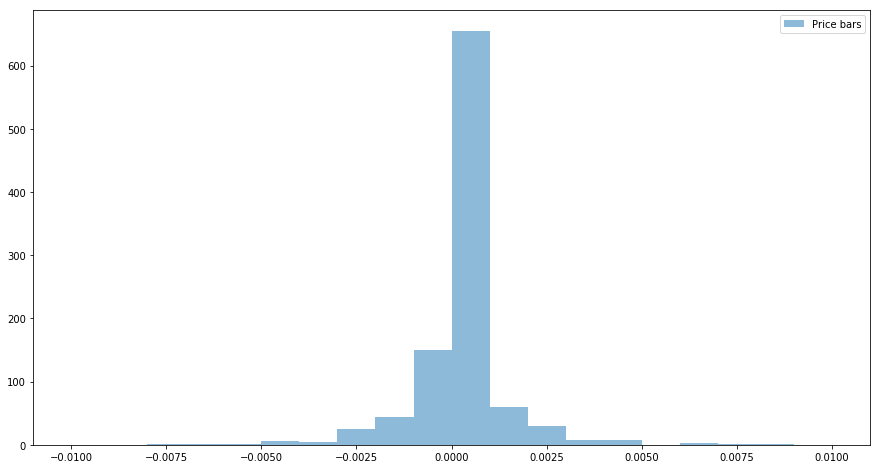

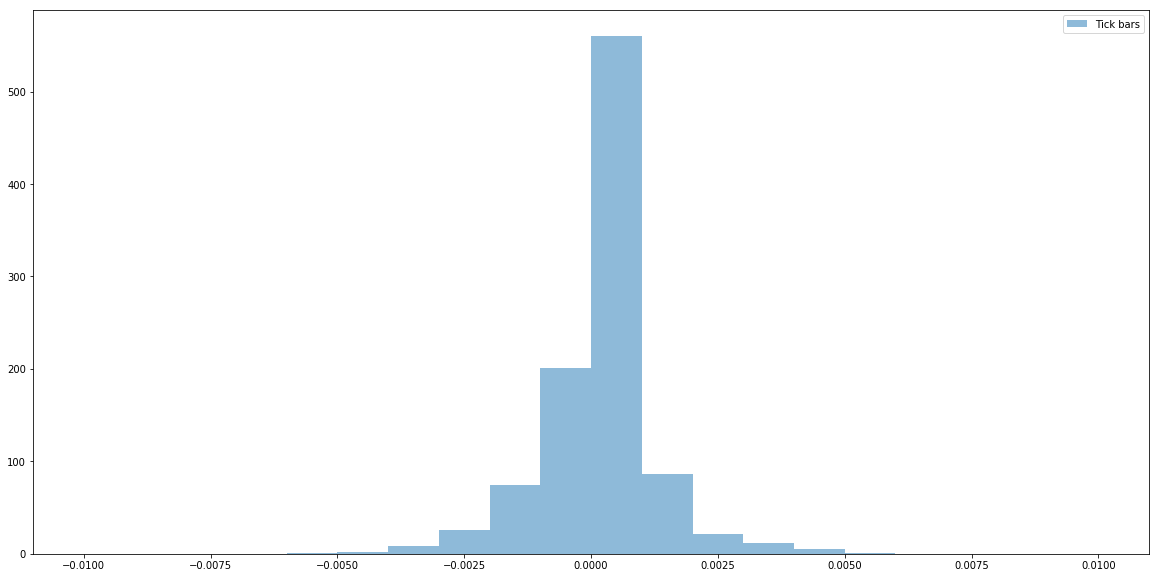

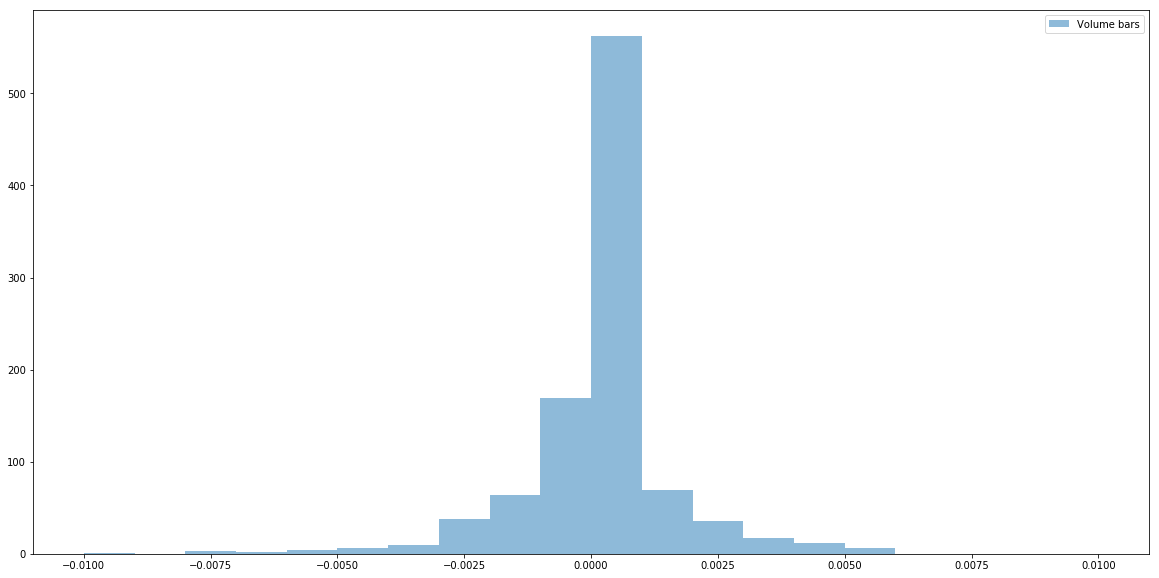

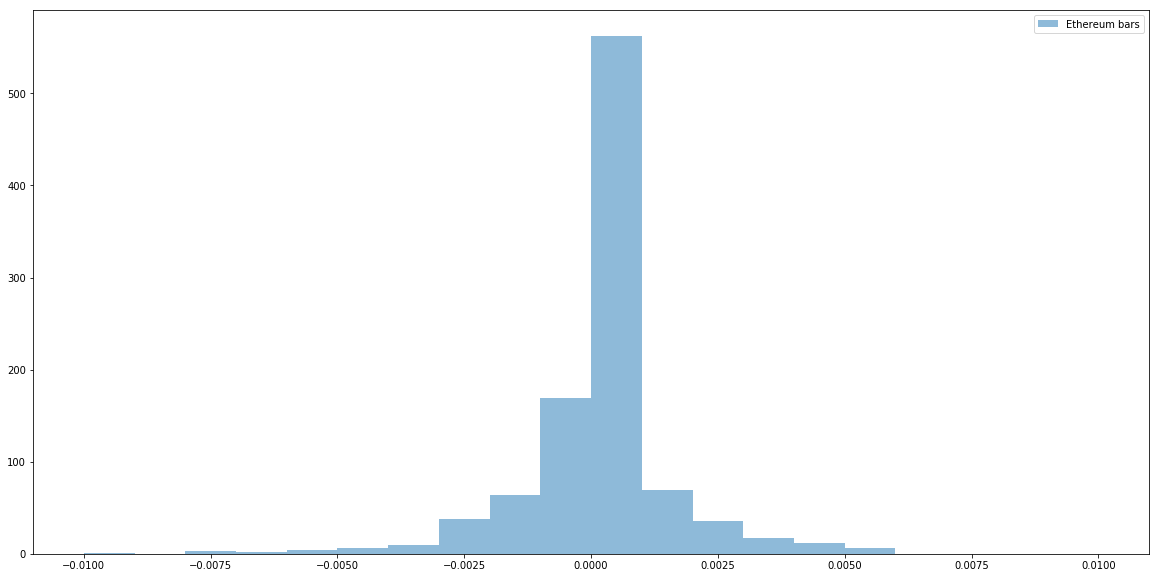

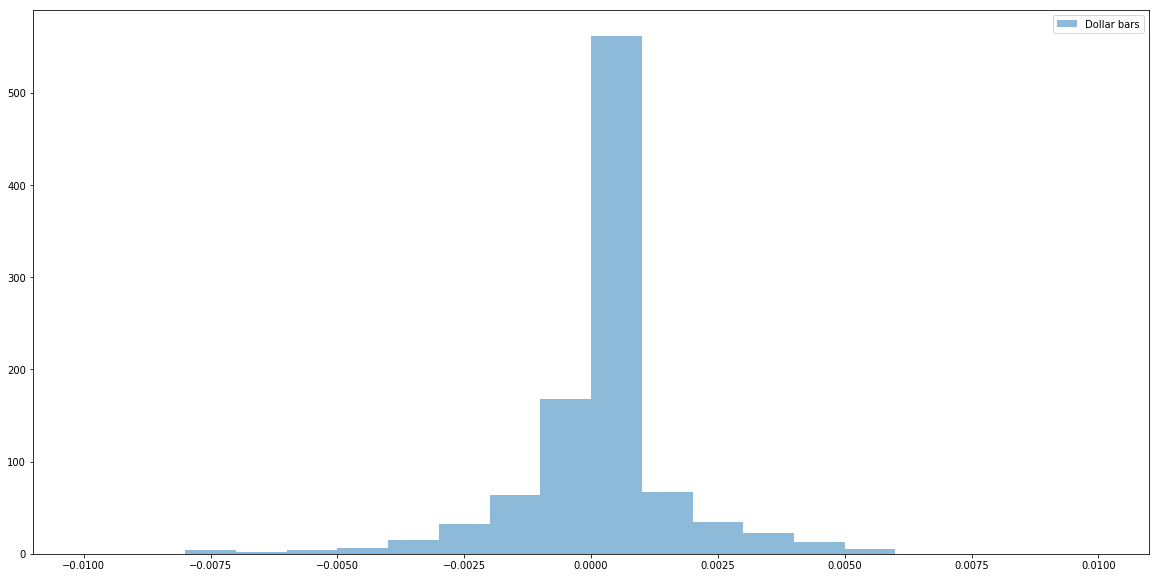

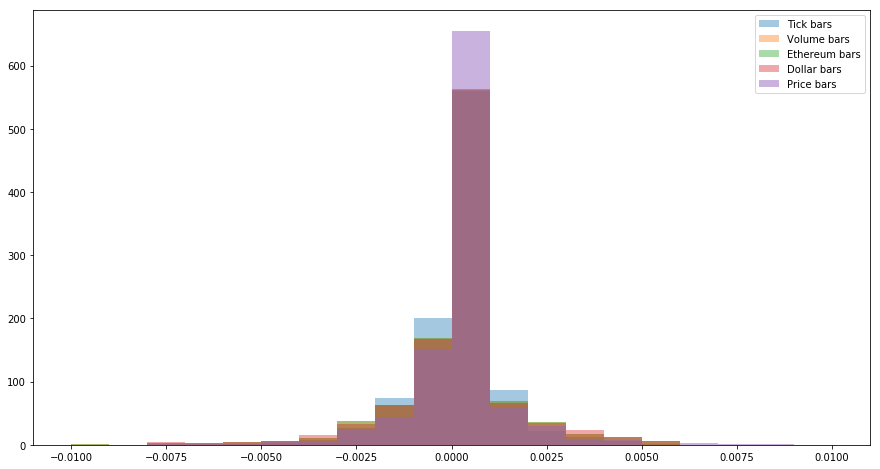

--------------------
--------------------
AUTOCORRELATIONS
-0.033503189313720906
0.19549593968013365
0.08751739377913549
0.08751739377913549
0.0692080229569218
--------------------
--------------------
VARIANCE
2.198360082975357e-06
1.4304449623515055e-06
2.420663895378985e-06
2.420663895378985e-06
2.4769425536966745e-06
--------------------
--------------------
JARQUE BERA TEST
(4452.509361225053, 0.0)
(1940.8696872471226, 0.0)
(1940.8696872471226, 0.0)
(1566.1624301176896, 0.0)


In [89]:
plt.figure(figsize = (15, 8))
plt.hist(ethbtc_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethbtc_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethbtc_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethbtc_ethereum_bars.close.pct_change().dropna().values.tolist(), label = 'Ethereum bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(ethbtc_bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Dollar bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (15, 8))

plt.hist(ethbtc_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(ethbtc_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(ethbtc_ethereum_bars.close.pct_change().dropna().values.tolist(), label = 'Ethereum bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(ethbtc_bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Dollar bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(ethbtc_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()
plt.show()

print('-' * 20)
print('-' * 20)
print("AUTOCORRELATIONS")
print(pd.Series.autocorr(ethbtc_time_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethbtc_tick_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethbtc_volume_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethbtc_ethereum_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(ethbtc_bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("VARIANCE")
print(np.var(ethbtc_time_bars.close.pct_change().dropna()))
print(np.var(ethbtc_tick_bars.close.pct_change().dropna()))
print(np.var(ethbtc_volume_bars.close.pct_change().dropna()))
print(np.var(ethbtc_ethereum_bars.close.pct_change().dropna()))
print(np.var(ethbtc_bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("JARQUE BERA TEST")
print(stats.jarque_bera(ethbtc_tick_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethbtc_volume_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethbtc_ethereum_bars.close.pct_change().dropna()))
print(stats.jarque_bera(ethbtc_bitcoin_bars.close.pct_change().dropna()))

## Plot EOS/BTC results

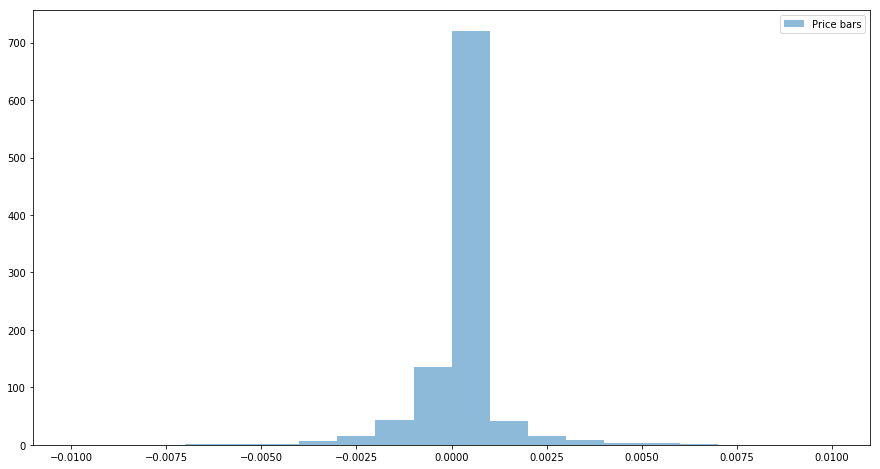

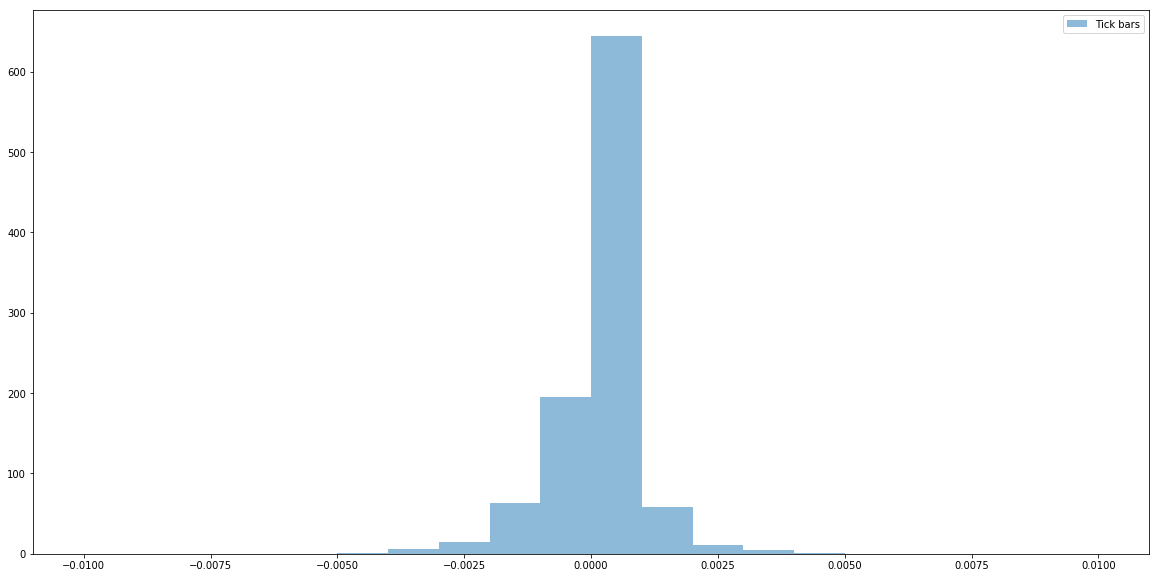

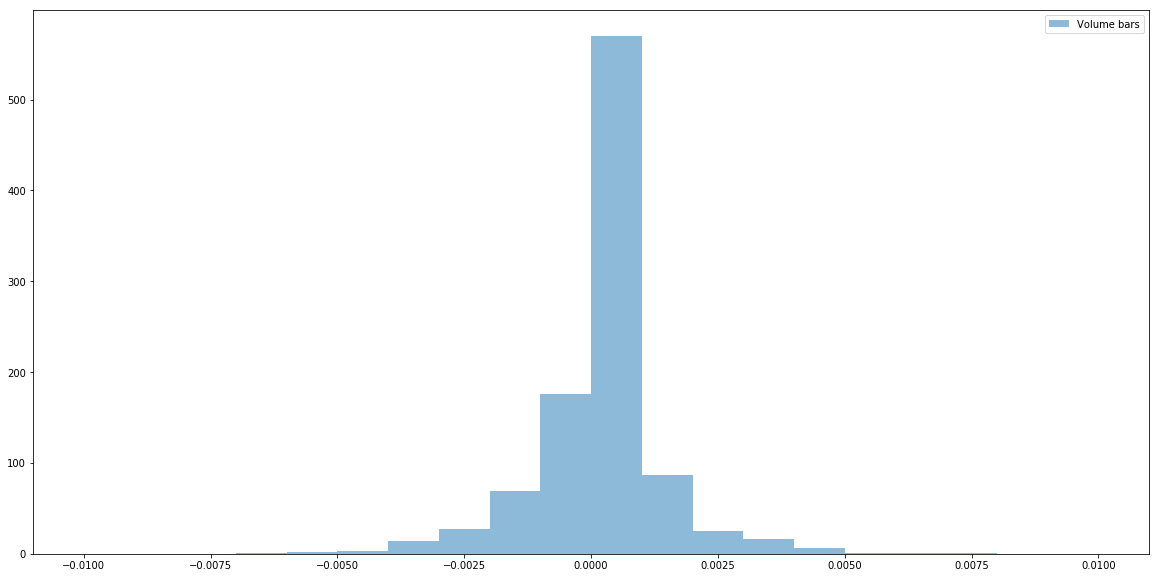

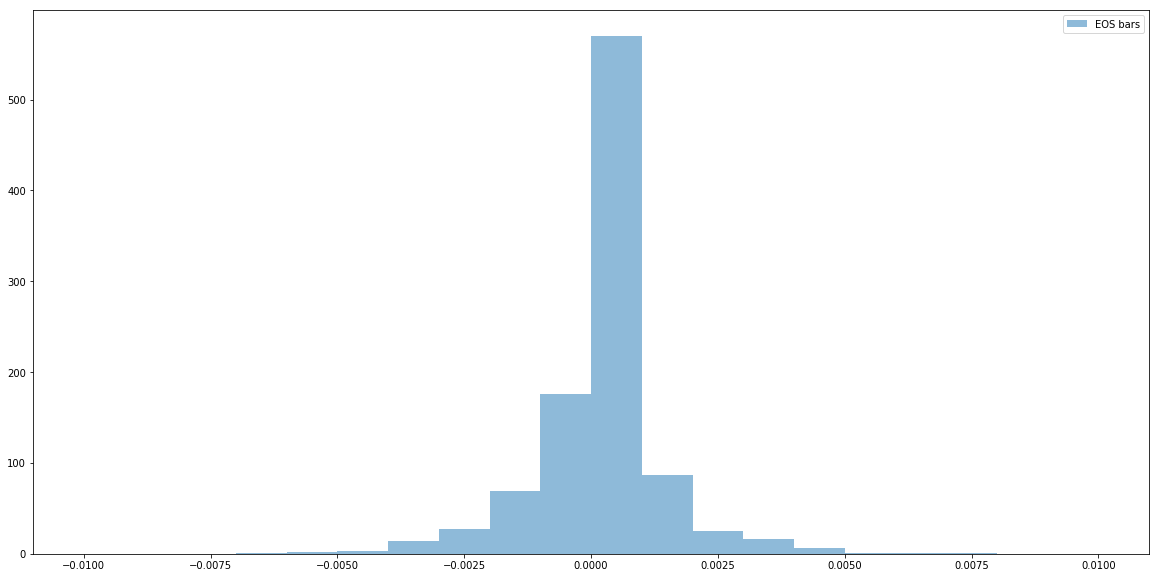

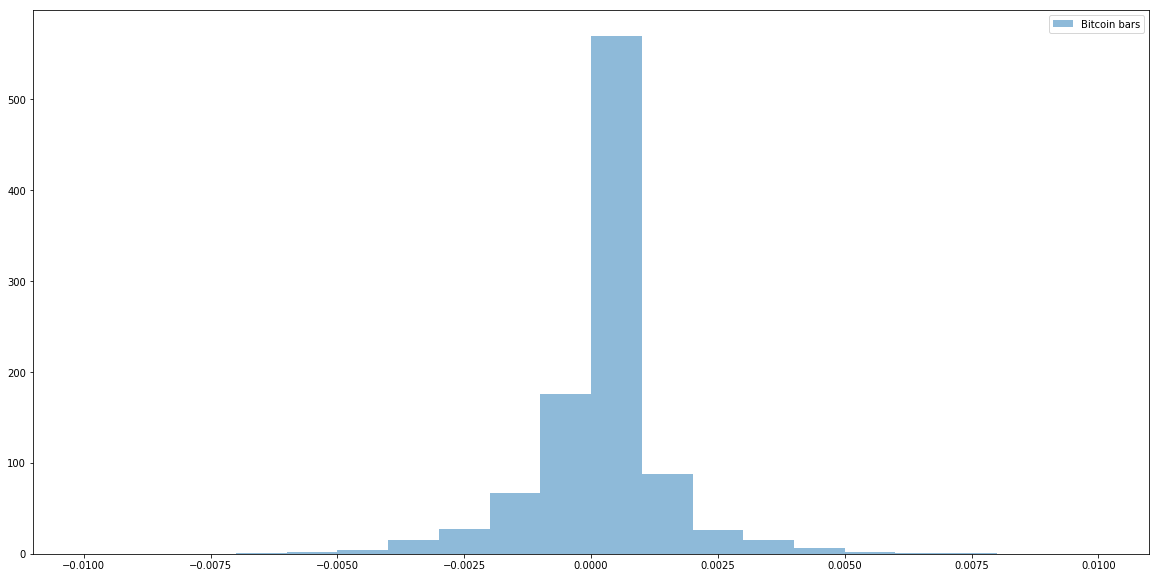

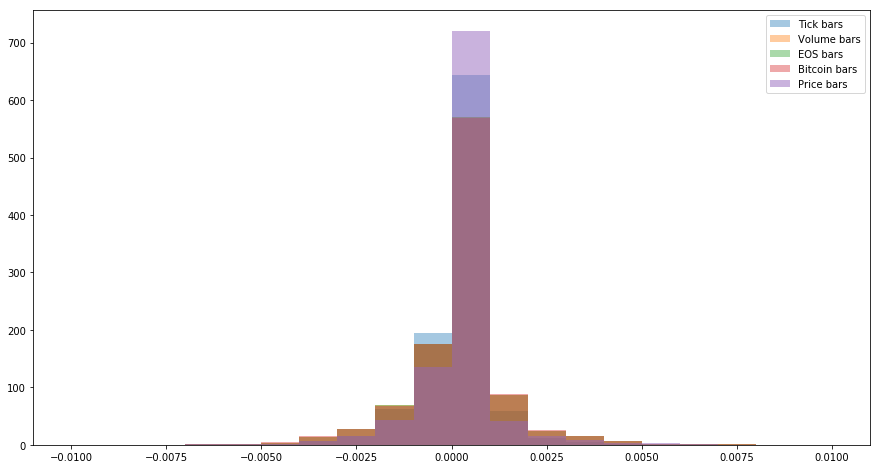

--------------------
--------------------
AUTOCORRELATIONS
0.09991320419121458
0.16103338335822825
0.1521593413468489
0.1521593413468489
0.14042888834371567
--------------------
--------------------
VARIANCE
1.3809577971341257e-06
7.44181489780324e-07
1.5261340648055838e-06
1.5261340648055838e-06
1.5481144263684044e-06
--------------------
--------------------
JARQUE BERA TEST
(547899.2286770279, 0.0)
(35510.736217163605, 0.0)
(6145.034629446508, 0.0)
(6145.034629446508, 0.0)
(6046.935908977818, 0.0)


In [112]:
plt.figure(figsize = (15, 8))
plt.hist(eosbtc_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(eosbtc_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(eosbtc_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(eosbtc_eos_bars.close.pct_change().dropna().values.tolist(), label = 'EOS bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (20, 10))
plt.hist(eosbtc_bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()

plt.figure(figsize = (15, 8))

plt.hist(eosbtc_tick_bars.close.pct_change().dropna().values.tolist(), label = 'Tick bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(eosbtc_volume_bars.close.pct_change().dropna().values.tolist(), label = 'Volume bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(eosbtc_eos_bars.close.pct_change().dropna().values.tolist(), label = 'EOS bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(eosbtc_bitcoin_bars.close.pct_change().dropna().values.tolist(), label = 'Bitcoin bars', alpha = 0.4, normed=True, bins=20, range = (-0.01, 0.01))
plt.hist(eosbtc_time_bars.close.pct_change().dropna().values.tolist(), label = 'Price bars', alpha = 0.5, normed=True, bins=20, range = (-0.01, 0.01))
plt.legend()
plt.show()

print('-' * 20)
print('-' * 20)
print("AUTOCORRELATIONS")
print(pd.Series.autocorr(eosbtc_time_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(eosbtc_tick_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(eosbtc_volume_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(eosbtc_eos_bars.close.pct_change().dropna()))
print(pd.Series.autocorr(eosbtc_bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("VARIANCE")
print(np.var(eosbtc_time_bars.close.pct_change().dropna()))
print(np.var(eosbtc_tick_bars.close.pct_change().dropna()))
print(np.var(eosbtc_volume_bars.close.pct_change().dropna()))
print(np.var(eosbtc_eos_bars.close.pct_change().dropna()))
print(np.var(eosbtc_bitcoin_bars.close.pct_change().dropna()))

print('-' * 20)
print('-' * 20)
print("JARQUE BERA TEST")
print(stats.jarque_bera(eosbtc_time_bars.close.pct_change().dropna()))
print(stats.jarque_bera(eosbtc_tick_bars.close.pct_change().dropna()))
print(stats.jarque_bera(eosbtc_volume_bars.close.pct_change().dropna()))
print(stats.jarque_bera(eosbtc_eos_bars.close.pct_change().dropna()))
print(stats.jarque_bera(eosbtc_bitcoin_bars.close.pct_change().dropna()))

## Plot BTC/USD Correlograms

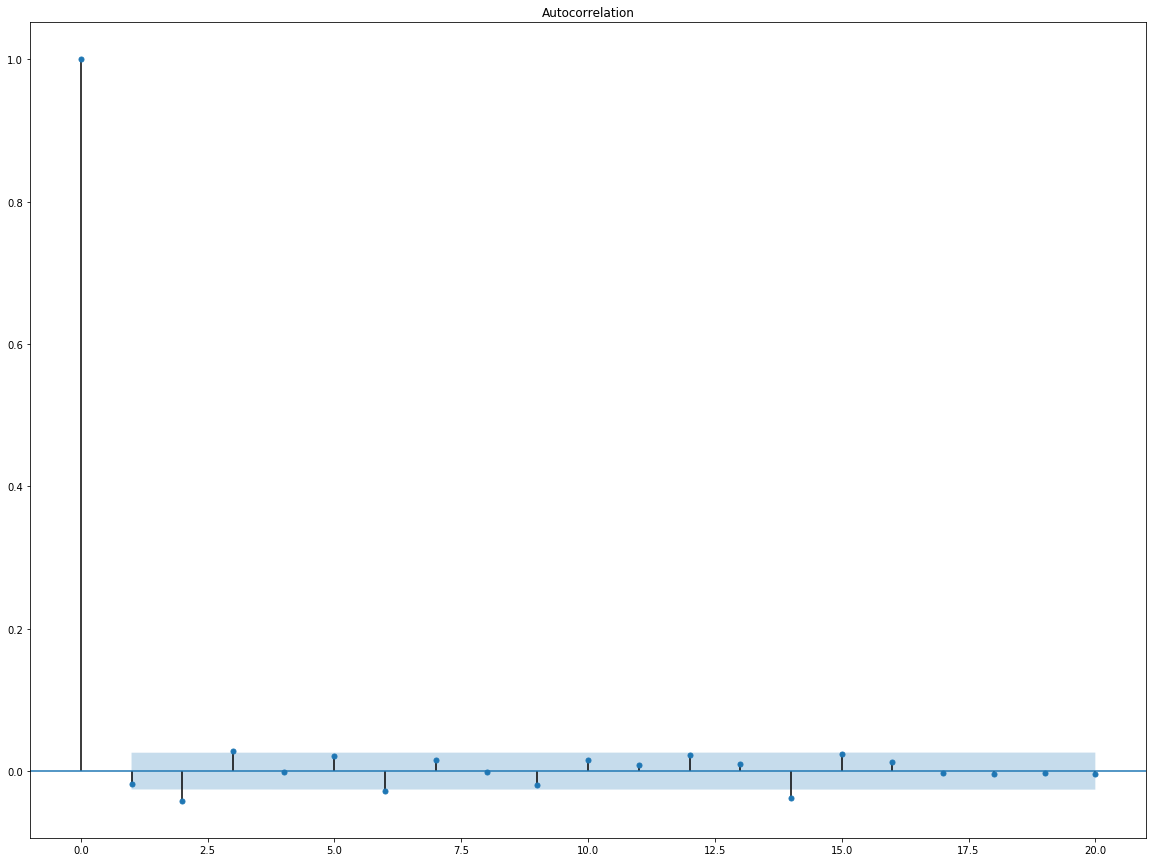

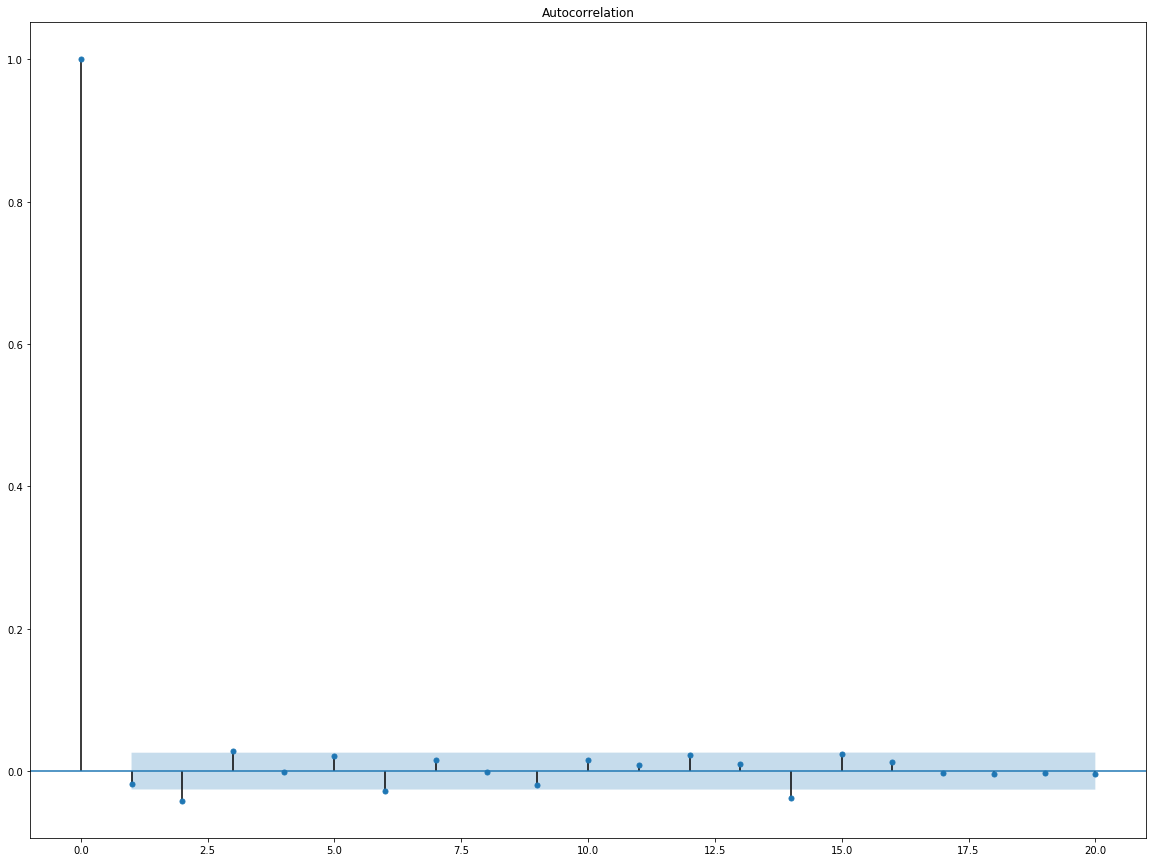

In [91]:
plot_acf(btcusd_time_bar_returns, lags=20)
plot_acf(btcusd_tick_bar_returns, lags=20)
plot_acf(btcusd_bitcoin_bars_returns, lags=20)
plot_acf(btcusd_bitcoin_bars_returns, lags=20)
plot_acf(btcusd_volume_bar_returns, lags=20)

## Plot ETH/USD Correlograms

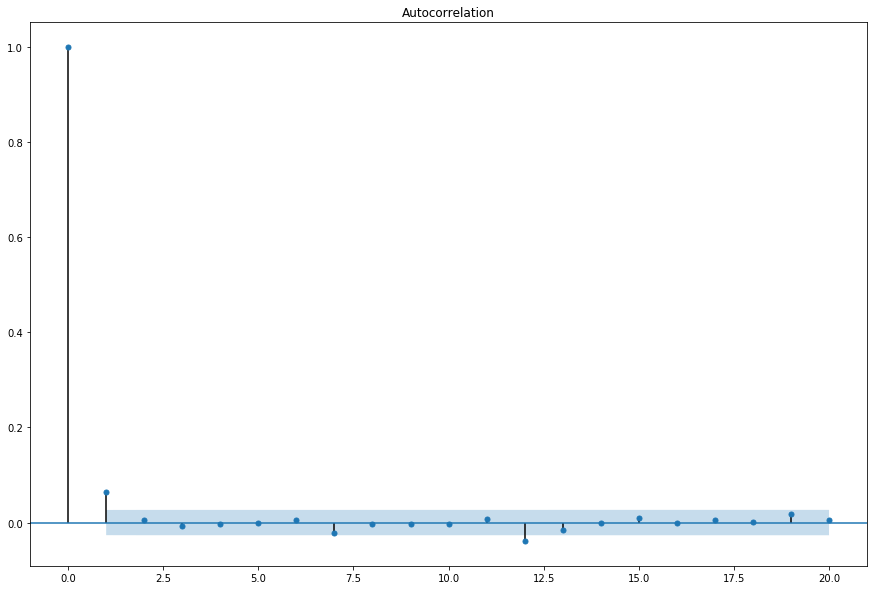

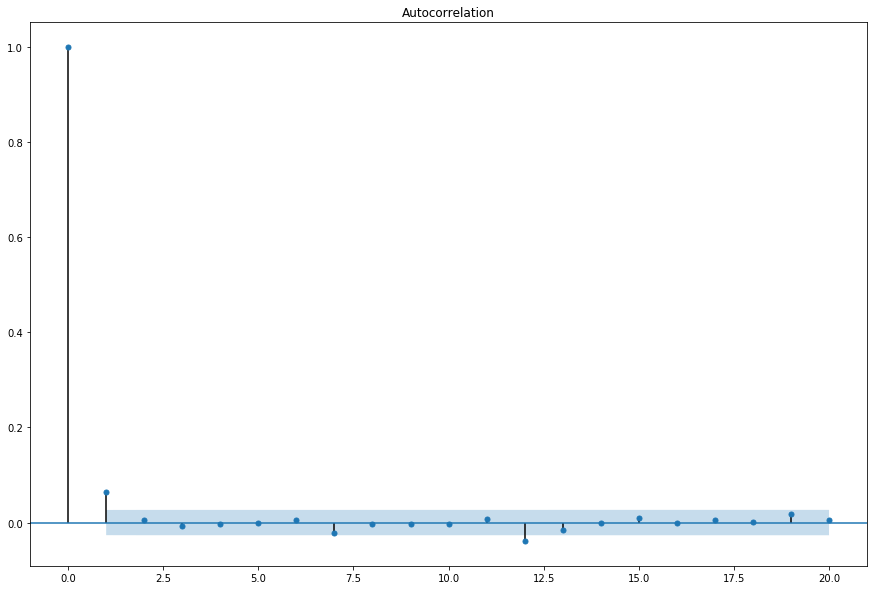

In [69]:
# plot_acf(ethusd_time_bar_returns, lags=20)
plot_acf(ethusd_tick_bar_returns, lags=20)
# plot_acf(ethusd_ethereum_bars_returns, lags=20)
# plot_acf(ethusd_dollar_bars_returns, lags=20)
# plot_acf(ethusd_volume_bar_returns, lags=20)

## Plot ETH/BTC Correlograms

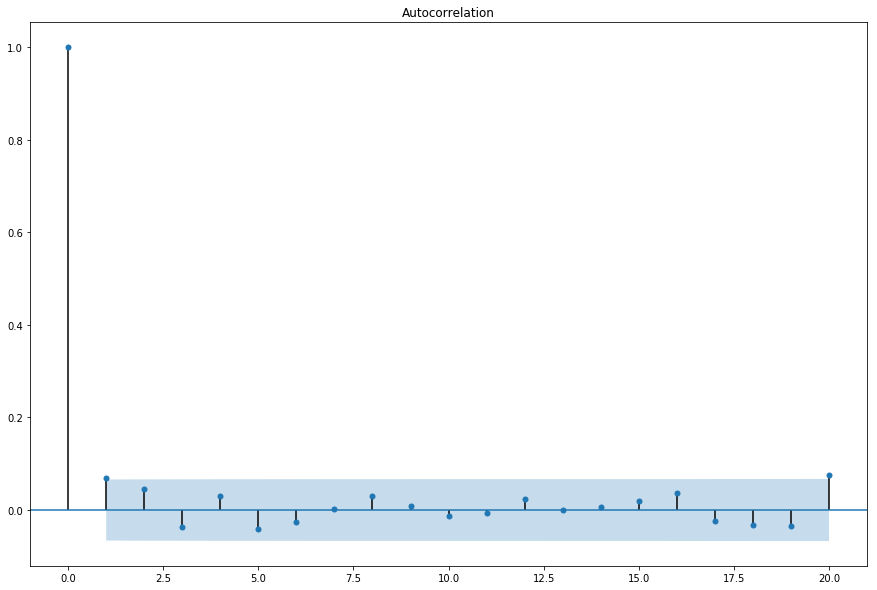

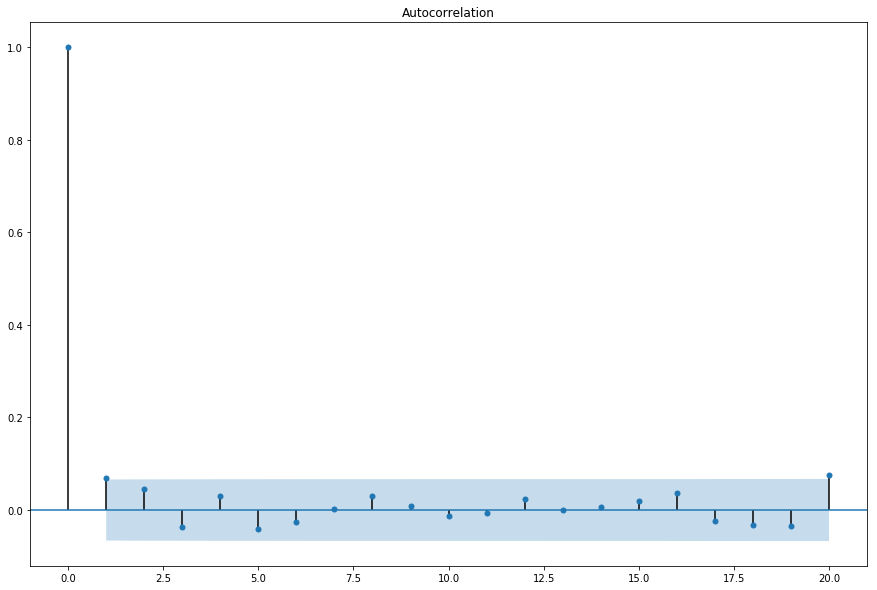

In [95]:
# plot_acf(ethbtc_time_bar_returns, lags=20)
# plot_acf(ethbtc_tick_bar_returns, lags=20)
# plot_acf(ethbtc_ethereum_bars_returns, lags=20)
plot_acf(ethbtc_bitcoin_bars_returns, lags=20)
# plot_acf(ethbtc_volume_bar_returns, lags=20)

## Plot EOS/BTC Correlograms

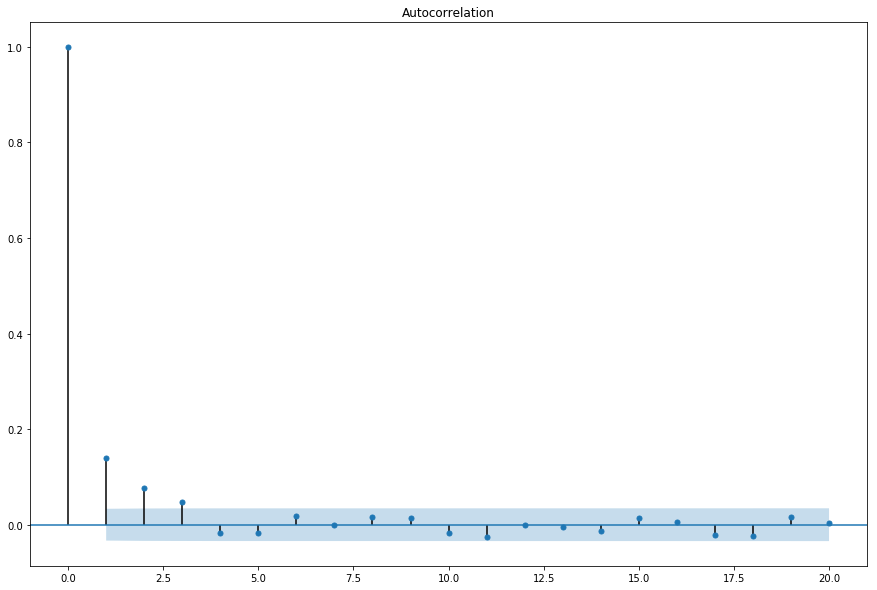

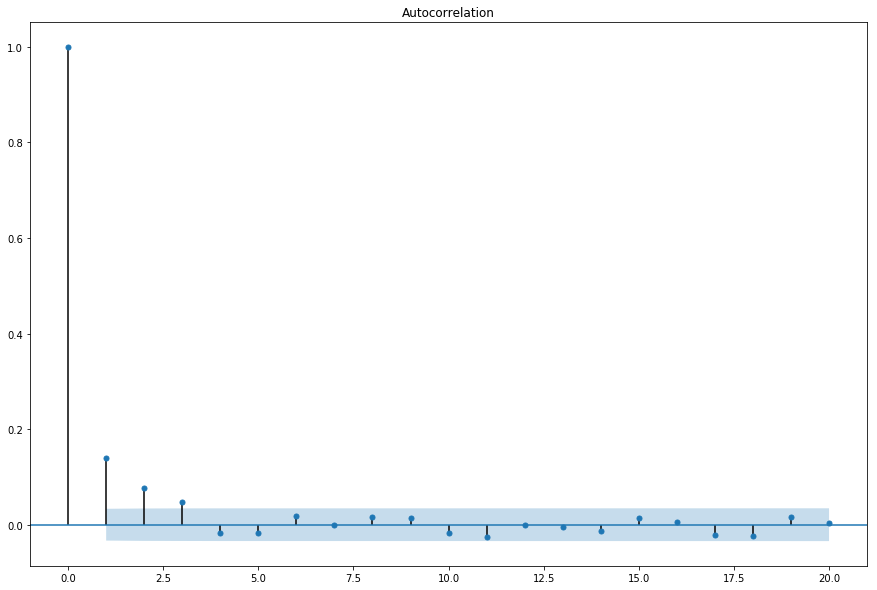

In [117]:
# plot_acf(eosbtc_time_bar_returns, lags=20)
# plot_acf(eosbtc_tick_bar_returns, lags=20)
# plot_acf(eosbtc_eos_bars_returns, lags=20)
plot_acf(eosbtc_bitcoin_bars_returns, lags=20)
# plot_acf(eosbtc_volume_bar_returns, lags=20)